## Credits:
The code in this notebook has been adopted from the Notebook published by [arunmohan_003]([url](https://www.kaggle.com/arunmohan003)) on Kaggle. Some changes have been made by the author.

In [12]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import stopwords 
from collections import Counter
import string
import re
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

In [13]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Animetx\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Animetx\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Animetx\AppData\Roaming\nltk_data...


True

In [14]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [ ]:
file_name = 'IMDB Dataset.csv'
df = pd.read_csv(file_name)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## Separacion del Dataset
Aqui he separado el dataset en dos, que es positivo y negativo, para luego usar SentimentIntensityAnalyzer para cada uno con su **score** y separarlos entre las diferentes clases:

In [36]:
df_positive = df[df['sentiment'] == 'positive']
df_negative = df[df['sentiment'] == 'negative']

df_positive.to_csv("dataset_positive.csv", index=False)
df_negative.to_csv("dataset_negative.csv", index=False)

print("Dataset positivo:", df_positive.shape)
print("Dataset negativo:", df_negative.shape)

Dataset positivo: (25000, 4)
Dataset negativo: (25000, 4)


## Creacion del Dataset Sintetico

En esta parte se implementa para ambos datasets generados, entre:

* -0.6 => "Muy malo"
* -0.2 => "Malo"
* "Regular"

* 0.6 => "Muy bueno"
* 0.2 => "Bueno"
* "Regular"

esto evitara reasignar los valores de Positivo y Negativo, asi solamente clasificandolo para cada uno entre sus correspondientes

In [ ]:
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

# --- Descargar VADER si no está ---
try:
    nltk.data.find('sentiment/vader_lexicon')
except LookupError:
    nltk.download('vader_lexicon', quiet=True)

sia = SentimentIntensityAnalyzer()

# --- Leer los datasets ---
df_positive = pd.read_csv("dataset_positive.csv")
df_negative = pd.read_csv("dataset_negative.csv")

# --- Calcular el compound si no existe ---
if 'compound' not in df_positive.columns:
    df_positive['compound'] = df_positive['review'].apply(lambda t: sia.polarity_scores(str(t))['compound'])
if 'compound' not in df_negative.columns:
    df_negative['compound'] = df_negative['review'].apply(lambda t: sia.polarity_scores(str(t))['compound'])

# --- Funciones para clasificar en 5 clases ---
def to_5class(score):
    if score >= 0.6:
        return "Muy bueno"
    elif score >= 0.2:
        return "Bueno"
    elif score > -0.2:
        return "Regular"
    elif score > -0.6:
        return "Malo"
    else:
        return "Muy malo"

# --- Funciones para clasificar en 5 clases (positivo y negativo separados) ---
def to_5class_positive(score):
    if score >= 0.6:
        return "Muy bueno"
    elif score >= 0.2:
        return "Bueno"
    else:
        return "Regular"

def to_5class_negative(score):
    if score <= -0.6:
        return "Muy malo"
    elif score <= -0.2:
        return "Malo"
    else:
        return "Regular"

# --- Aplicar las funciones ---
df_positive['sentiment_5class'] = df_positive['compound'].apply(to_5class_positive)
df_negative['sentiment_5class'] = df_negative['compound'].apply(to_5class_negative)

# --- Combinar los datasets ---
df_final = pd.concat([df_positive, df_negative], ignore_index=True)

# -- Guardar el dataset final ---
df_final.to_csv("dataset_5clases.csv", index=False)

# --- Mostrar algunas filas del dataset final ---
print(df_final[["review", "compound", "sentiment_5class"]].head(10))


                                              review  compound  \
0  One of the other reviewers has mentioned that ...   -0.9951   
1  A wonderful little production. <br /><br />The...    0.9641   
2  I thought this was a wonderful way to spend ti...    0.9605   
3  Petter Mattei's "Love in the Time of Money" is...    0.9744   
4  Probably my all-time favorite movie, a story o...    0.9828   
5  I sure would like to see a resurrection of a u...    0.9022   
6  If you like original gut wrenching laughter yo...    0.9149   
7  This a fantastic movie of three prisoners who ...    0.6168   
8  Some films just simply should not be remade. T...    0.3506   
9  I remember this film,it was the first film i h...    0.6518   

  sentiment_5class  
0          Regular  
1        Muy bueno  
2        Muy bueno  
3        Muy bueno  
4        Muy bueno  
5        Muy bueno  
6        Muy bueno  
7        Muy bueno  
8            Bueno  
9        Muy bueno  


In [54]:
file_name = 'dataset_5clases.csv'
df = pd.read_csv(file_name)
df.head()

,review,sentiment,compound,sentiment_5class
0,One of the other reviewers has mentioned that ...,positive,-0.9951,Regular
1,A wonderful little production. <br /><br />The...,positive,0.9641,Muy bueno
2,I thought this was a wonderful way to spend ti...,positive,0.9605,Muy bueno
3,"Petter Mattei's ""Love in the Time of Money"" is...",positive,0.9744,Muy bueno
4,"Probably my all-time favorite movie, a story o...",positive,0.9828,Muy bueno


In [51]:
# Use the 5-class sentiment labels as target
X, y = df['review'].values, df['sentiment_5class'].values
x_train,x_test,y_train,y_test = train_test_split(X,y,stratify=y)
print(f'train data shape: {x_train.shape}')
print(f'test data shape: {x_test.shape}')

train data shape: (37500,)
test data shape: (12500,)


C:\Users\Animetx\AppData\Local\Temp\ipykernel_8604\179684215.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=order, y=values_ordered, palette="viridis")


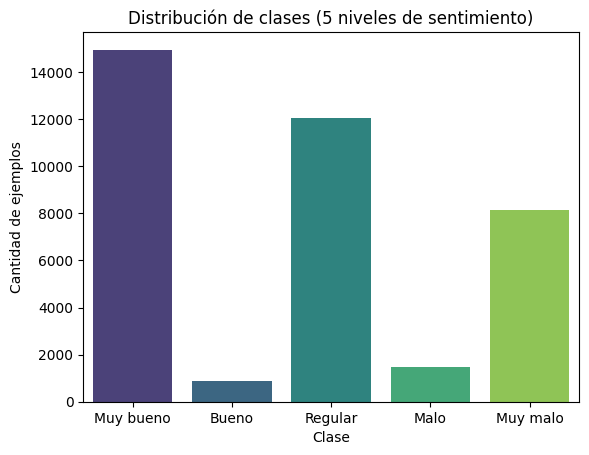

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Conteo de clases
dd = pd.Series(y_train).value_counts()

# 
order = ['Muy bueno', 'Bueno', 'Regular', 'Malo', 'Muy malo']

values_ordered = [dd.get(label, 0) for label in order]

sns.barplot(x=order, y=values_ordered, palette="viridis")
plt.title("Distribución de clases (5 niveles de sentimiento)")
plt.xlabel("Clase")
plt.ylabel("Cantidad de ejemplos")
plt.show()

Con la grafica podemos ver como los muy bueno y muy malo no estan tan disparejo, esto se debe a que algunos valores se fueron a regular.

Una alternativa encontrada y mas efectiva es crearse arrays con palabras que indiquen si es, bueno, malo, etc, asi luego clasificar a cada clase

In [57]:
def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with single space
    s = re.sub(r"\s+", ' ', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)
    return s.strip()


def tokenize(x_train,y_train,x_val,y_val):
    word_list = []

    stop_words = set(stopwords.words('english')) 
    for sent in x_train:
        for word in str(sent).lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)
  
    corpus = Counter(word_list)
    # sorting on the basis of most common words
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:1000]
    # creating a dict
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}
    
    # tokenize
    final_list_train,final_list_test = [],[]
    for sent in x_train:
            final_list_train.append([onehot_dict[preprocess_string(word)] for word in str(sent).lower().split() 
                                     if preprocess_string(word) in onehot_dict.keys()])
    for sent in x_val:
            final_list_test.append([onehot_dict[preprocess_string(word)] for word in str(sent).lower().split() 
                                    if preprocess_string(word) in onehot_dict.keys()])
            
    # Map 5-class labels to integers
    label_map = {"Muy malo":0, "Malo":1, "Regular":2, "Bueno":3, "Muy bueno":4}
    encoded_train = [label_map[label] for label in y_train]
    encoded_test = [label_map[label] for label in y_val]
    return (
        np.array(final_list_train, dtype=object),
        np.array(encoded_train),
        np.array(final_list_test, dtype=object),
        np.array(encoded_test),
        onehot_dict
    )
    # return np.array(final_list_train), np.array(encoded_train),np.array(final_list_test), np.array(encoded_test),onehot_dict

In [58]:
x_train,y_train,x_test,y_test,vocab = tokenize(x_train,y_train,x_test,y_test)

In [59]:
print(f'Length of vocabulary is {len(vocab)}')

Length of vocabulary is 1000


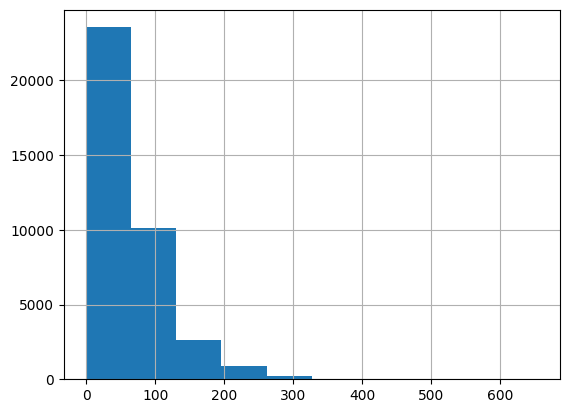

count    37500.000000
mean        69.000693
std         48.019233
min          0.000000
25%         39.000000
50%         54.000000
75%         84.000000
max        653.000000
dtype: float64

In [60]:
rev_len = [len(i) for i in x_train]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()

In [61]:
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

In [62]:
#we have very less number of reviews with length > 500.
#So we will consideronly those below it.
x_train_pad = padding_(x_train,500)
x_test_pad = padding_(x_test,500)

In [63]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test))

# dataloaders
batch_size = 50

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

In [64]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = next(dataiter)

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample output: \n', sample_y)

Sample input size:  torch.Size([50, 500])
Sample input: 
 tensor([[  0,   0,   0,  ..., 101,   5, 235],
        [  0,   0,   0,  ..., 341,  44,   1],
        [  0,   0,   0,  ...,  39, 638,   3],
        ...,
        [  0,   0,   0,  ..., 259,  18,   3],
        [  0,   0,   0,  ...,   2, 154, 324],
        [  0,   0,   0,  ...,   1,   3, 317]])
Sample output: 
 tensor([4, 4, 2, 4, 2, 2, 2, 4, 2, 4, 4, 4, 4, 4, 4, 4, 0, 2, 1, 4, 4, 4, 0, 2,
        4, 4, 0, 4, 2, 0, 0, 4, 4, 4, 2, 0, 2, 0, 2, 0, 3, 2, 2, 4, 4, 2, 1, 0,
        2, 2])


In [65]:
class SentimentRNN(nn.Module):
    def __init__(self,no_layers,vocab_size,hidden_dim,output_dim,embedding_dim,drop_prob=0.5):
        super(SentimentRNN,self).__init__()
 
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
 
        self.no_layers = no_layers
        self.vocab_size = vocab_size
    
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        #lstm
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                           num_layers=no_layers, batch_first=True)
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
    
        # linear layer to produce logits for each class
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        
    def forward(self,x,hidden):
        batch_size = x.size(0)
        # embeddings and lstm_out
        embeds = self.embedding(x)  # shape: B x S x Feature
        lstm_out, hidden = self.lstm(embeds, hidden)
        
        # reshape for fully connected: (B*S, H)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        out = self.dropout(lstm_out)
        out = self.fc(out)  # (B*S, output_dim)
        
        # reshape to (B, S, output_dim) and take last time step
        out = out.view(batch_size, -1, self.output_dim)
        out = out[:, -1, :]  # (batch_size, output_dim) -> logits
        
        return out, hidden
        
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden

In [66]:
no_layers = 2
vocab_size = len(vocab) + 1 #extra 1 for padding
embedding_dim = 64
output_dim = 5  # 5 classes: Muy malo, Malo, Regular, Bueno, Muy bueno
hidden_dim = 256

model = SentimentRNN(no_layers,vocab_size,hidden_dim,output_dim,embedding_dim,drop_prob=0.5)

#moving to gpu
model.to(device)

print(model)

SentimentRNN(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=5, bias=True)
)


In [67]:
# loss and optimization functions
lr=0.001

# Use CrossEntropyLoss for multiclass classification
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# function to predict accuracy
def acc(pred,label):
    # pred: logits (batch_size, num_classes)
    preds = pred.argmax(dim=1)
    return torch.sum(preds == label).item()


In [68]:
clip = 5
epochs = 5 
valid_loss_min = np.inf
# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()
    # initialize hidden state 
    h = model.init_hidden(batch_size)
    for inputs, labels in train_loader:
        
        inputs, labels = inputs.to(device), labels.to(device)
        # ensure labels are long for CrossEntropyLoss
        labels = labels.long()
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])
        
        model.zero_grad()
        output,h = model(inputs,h)
        
        # calculate the loss and perform backprop
        loss = criterion(output, labels)
        loss.backward()
        train_losses.append(loss.item())
        # calculating accuracy
        accuracy = acc(output,labels)
        train_acc += accuracy
        #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_loader:
            val_h = tuple([each.data for each in val_h])

            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.long()

            output, val_h = model(inputs, val_h)
            val_loss = criterion(output, labels)

            val_losses.append(val_loss.item())
            
            accuracy = acc(output,labels)
            val_acc += accuracy
            
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}') 
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    if epoch_val_loss <= valid_loss_min:
        torch.save(model.state_dict(), 'state_dict.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
        valid_loss_min = epoch_val_loss
    print(25*'==')

Epoch 1
train_loss : 1.113114371140798 val_loss : 0.962907502412796
train_accuracy : 51.90933333333333 val_accuracy : 60.392
Validation loss decreased (inf --> 0.962908).  Saving model ...
Epoch 2
train_loss : 0.89200239888827 val_loss : 0.8532555885314942
train_accuracy : 64.44266666666667 val_accuracy : 65.712
Validation loss decreased (0.962908 --> 0.853256).  Saving model ...
Epoch 3
train_loss : 0.8258977699677149 val_loss : 0.8341404497623444
train_accuracy : 67.624 val_accuracy : 67.05600000000001
Validation loss decreased (0.853256 --> 0.834140).  Saving model ...
Epoch 4
train_loss : 0.7850840598742167 val_loss : 0.8183592257499694
train_accuracy : 69.408 val_accuracy : 67.60000000000001
Validation loss decreased (0.834140 --> 0.818359).  Saving model ...
Epoch 5
train_loss : 0.7409900192022324 val_loss : 0.822370236992836
train_accuracy : 71.384 val_accuracy : 67.752


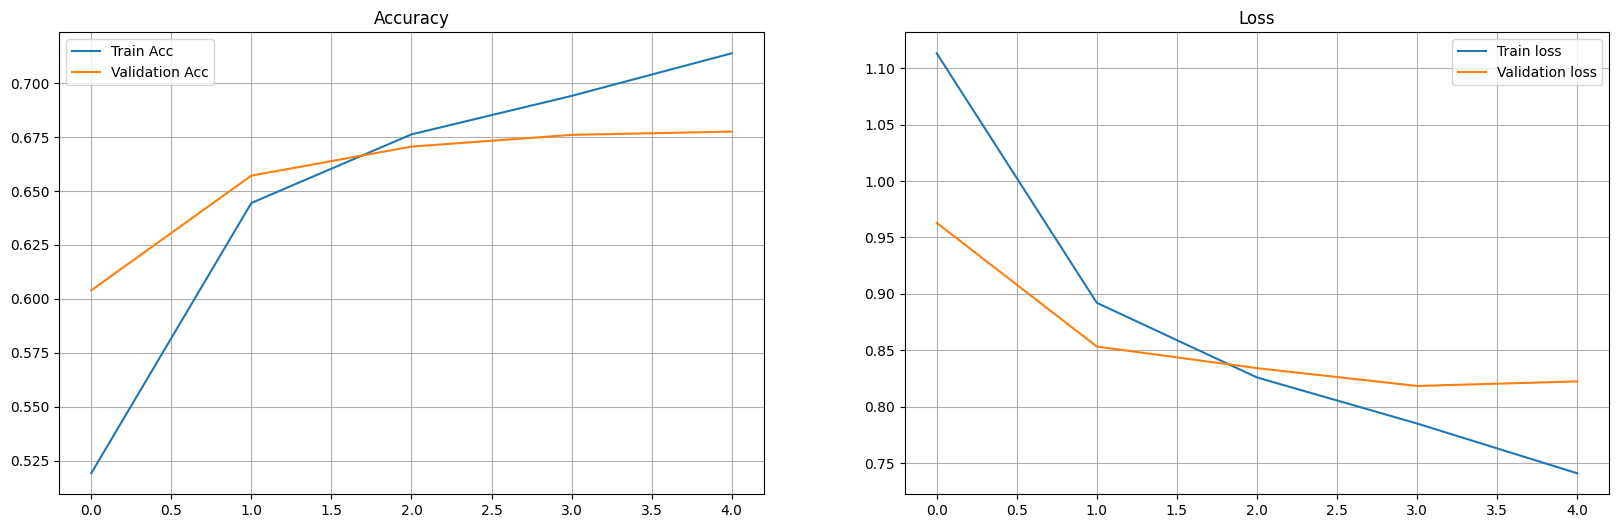

In [69]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()
    
plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

In [70]:
def predict_text(text):
        word_seq = np.array([vocab[preprocess_string(word)] for word in text.split() 
                         if preprocess_string(word) in vocab.keys()])
        word_seq = np.expand_dims(word_seq,axis=0)
        pad =  torch.from_numpy(padding_(word_seq,500))
        inputs = pad.to(device)
        batch_size = 1
        h = model.init_hidden(batch_size)
        h = tuple([each.data for each in h])
        output, h = model(inputs, h)  # logits
        probs = torch.softmax(output, dim=1)
        prob, idx = torch.max(probs, dim=1)
        idx = idx.item()
        prob = prob.item()
        idx2label = {0:'Muy malo', 1:'Malo', 2:'Regular', 3:'Bueno', 4:'Muy bueno'}
        return idx2label[idx], prob

In [71]:
index = 300
print(df['review'][index])
print('='*70)
print(f'Actual sentiment is  : {df["sentiment_5class"][index]}')
print('='*70)
label, prob = predict_text(df['review'][index])
print(f'Predicted sentiment is {label} with a probability of {prob:.3f}')

Let's keep it simple: My two kids were glued to this movie. It has its flaws from an adult perspective, but buy some jelly-worms and just enjoy it. <br /><br />And the Pepsi girl was excellent!<br /><br />And Kimberly Williams was pretty gosh-darned hot, although she's not in the film very much, so don't get too excited there.<br /><br />Not that's it's really a bad thing, but it is the kind of movie you watch just once. Don't buy the DVD.<br /><br />Enjoy!<br /><br />Did I mention Kimberly Williams? (That was for the dads.)
Actual sentiment is  : Bueno
Predicted sentiment is Muy bueno with a probability of 0.488


In [72]:
index = 32
print(df['review'][index])
print('='*70)
print(f'Actual sentiment is  : {df["sentiment_5class"][index]}')
print('='*70)
label, prob = predict_text(df['review'][index])
print(f'Predicted sentiment is {label} with a probability of {prob:.3f}')

I am not a golf fan by any means. On May 26 about 10:30 PM the movie started with a scene in the late 1800's. Old movies I like but not golf however, within the first scene a young boy (Harry Vardon) is awaken by the voices of men. He goes outside to inquire what they are doing and is told they are going to build a golf something... So , then I turned the television off but something stirred me and it was back on. The movie is excellent. We then see this young boy now a man; professional golf player who is haunted with visions from his childhood. Then we meet the true focus of the movie Francis and the decisions he makes for golf. You meet his mother and father who want to protect him from the class thing that is so obvious during the period. Then there is little Eddie Lowery his caddy with encouraging words and little pushes that are instrumental in Francis winning. Don't want to give away too much . I was up until 2 A.M. This is super please see the movie.
Actual sentiment is  : Muy 